In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.size": 16,
    }
)

# Most of this notebook can be run on CPU in a reasonable amount of time.
# The example training at the end cannot be.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Desired duration of time-domain waveform
waveform_duration = 60
# Sample rate of all the data we'll be using today
sample_rate = 2048

# Define minimum, maximum, and reference frequencies
f_min = 20
f_max = 1024
f_ref = 20

nyquist = sample_rate / 2
num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1

# Create an array of frequency values at which to generate our waveform
# At the moment, only frequency-domain approximants have been implemented
frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
freq_mask = (frequencies >= f_min) * (frequencies < f_max).to(device)

In [3]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction, UniformComovingVolume
from torch.distributions import Uniform

# On CPU, keep the number of waveforms around 100. On GPU, you can go higher
num_waveforms = 10

param_dict = {
    "chirp_mass": Uniform(1.17, 2.2),          # solar masses
    "mass_ratio": Uniform(0.6, 1.0),          # BNS are near equal mass
    "chi1": DeltaFunction(0),             # NS have small spins
    "chi2": DeltaFunction(0),
    "distance": UniformComovingVolume(10,500,distance_type='luminosity_distance'), #PowerLaw(40, 200, 2),         # closer sources (weaker signals)
    "phic": Uniform(0, 2 * torch.pi),  # isotropic in phase
    "inclination": Sine(),
}

# And then sample from each of those distributions
params = {
    k: v.sample((num_waveforms,)).to(device) for k, v in param_dict.items()
}

In [4]:
from ml4gw.waveforms import IMRPhenomD

approximant = IMRPhenomD().to(device)

# Calling the approximant with the frequency array, reference frequency, and waveform parameters
# returns the cross and plus polarizations
hc_f, hp_f = approximant(f=frequencies[freq_mask], f_ref=f_ref, **params)
print(hc_f.shape, hp_f.shape)

torch.Size([10, 60240]) torch.Size([10, 60240])


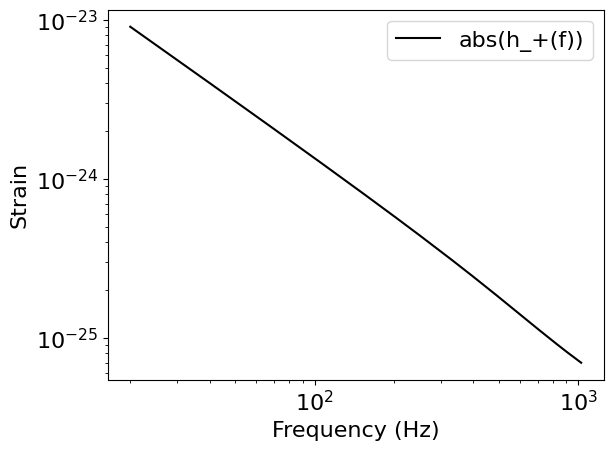

In [5]:
# Note that I have to move data to CPU to plot
# In an actual training setup, you wouldn't be moving data between devices so much
plt.plot(frequencies[freq_mask].cpu(), torch.abs(hp_f[0]).cpu(), label='abs(h_+(f))',color='black')
# plt.plot(frequencies[freq_mask].cpu(), hp_f[0].cpu().real, label='Re[h_+(f)]',color='royalblue')
# plt.plot(frequencies[freq_mask].cpu(), hp_f[0].cpu().imag, label='Im[h_+(f)]', linestyle='--',color='firebrick')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
# plt.xlim(0, 100)
plt.legend(loc='best')
plt.show()

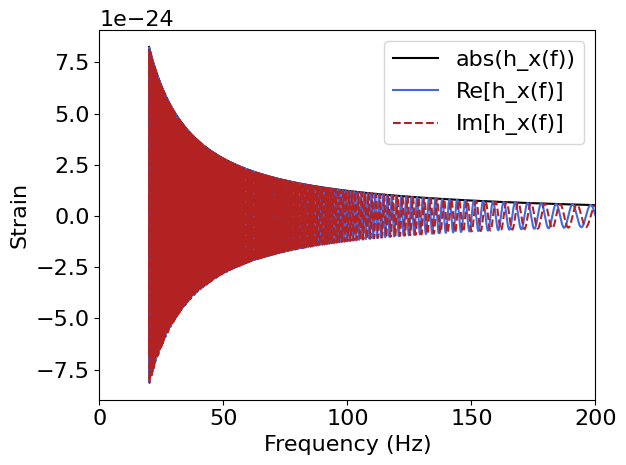

In [6]:
# Note that I have to move data to CPU to plot
# In an actual training setup, you wouldn't be moving data between devices so much
plt.plot(frequencies[freq_mask].cpu(), torch.abs(hc_f[0]).cpu(), label='abs(h_x(f))',color='black')
plt.plot(frequencies[freq_mask].cpu(), hc_f[0].cpu().real, label='Re[h_x(f)]',color='royalblue')
plt.plot(frequencies[freq_mask].cpu(), hc_f[0].cpu().imag, label='Im[h_x(f)]', linestyle='--',color='firebrick')
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.xlim(0, 200)
plt.legend(loc='best')
plt.show()

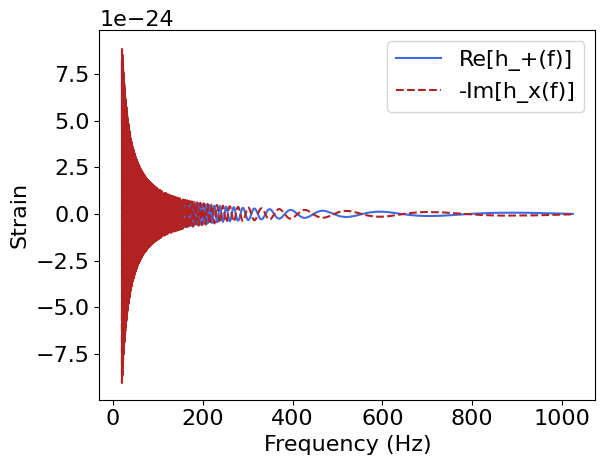

In [7]:
plt.plot(frequencies[freq_mask].cpu(), hc_f[0].cpu().real, label='Re[h_+(f)]',color='royalblue') #Im h_x = Re h_+
plt.plot(frequencies[freq_mask].cpu(), -hp_f[0].cpu().imag, label='-Im[h_x(f)]', linestyle='--',color='firebrick')
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
# plt.xlim(0, 200)
plt.legend(loc='best')
plt.show()

In [8]:
# create spectrum of frequencies, initially filled with zeros,
# with a delta_f such that after we fft to time domain the duration
# of the waveform will be waveform_duration
shape = (hc_f.shape[0], num_freqs)
hc_spectrum = torch.zeros(shape, dtype=hc_f.dtype, device=device)
hp_spectrum = torch.zeros(shape, dtype=hc_f.dtype, device=device)

# fill the spectrum with the
# hc and hp values at the specified frequencies
hc_spectrum[:, freq_mask] = hc_f
hp_spectrum[:, freq_mask] = hp_f

# now, irfft and scale the waveforms by sample_rate
hc, hp = torch.fft.irfft(hc_spectrum), torch.fft.irfft(hp_spectrum)
hc *= sample_rate
hp *= sample_rate

# The coalescence point is placed at the right edge, so shift it to
# give some room for ringdown
ringdown_duration = 0.5
ringdown_size = int(ringdown_duration * sample_rate)
hc = torch.roll(hc, -ringdown_size, dims=-1)
hp = torch.roll(hp, -ringdown_size, dims=-1)
print(hc.shape, hp.shape)

torch.Size([10, 122880]) torch.Size([10, 122880])


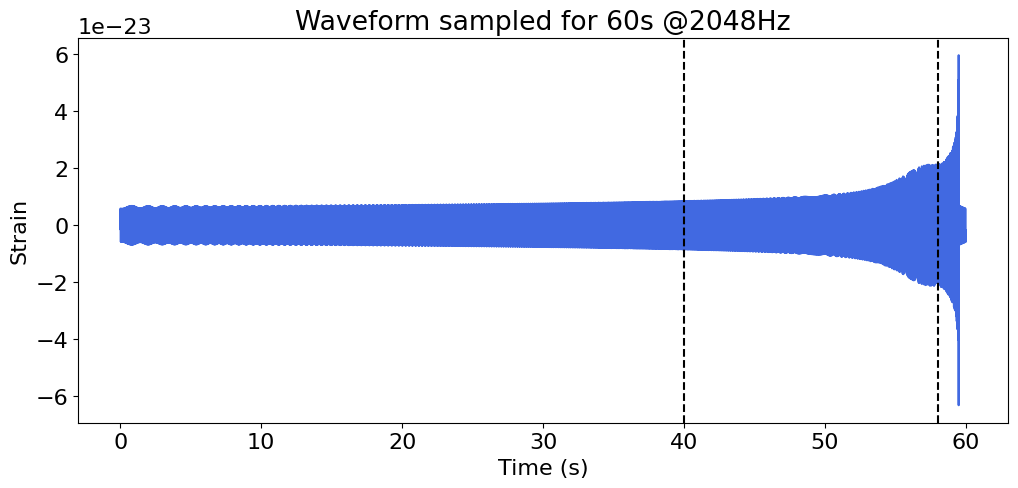

In [9]:
plt.figure(figsize=(12,5))
times = torch.arange(0, waveform_duration, 1 / sample_rate)
plt.plot(times, hp[0].cpu(), color='royalblue')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title('Waveform sampled for 60s @2048Hz')
plt.axvline(40, linestyle='--', color='black')
plt.axvline(58, linestyle='--', color='black')
# plt.xlim(0,62)
plt.show()

In [10]:
def generate_bns_waveforms(
    num_waveforms=1000,
    waveform_duration=60,
    sample_rate=2048,
    f_min=20,
    f_max=1024,
    f_ref=20,
    device=None,
    params_dict=None,
    ringdown_duration=0.5
):
    """
    Generate frequency-domain and time-domain gravitational wave polarizations for BNS systems.

    Parameters
    ----------
    num_waveforms : int
        Number of waveforms to generate
    waveform_duration : float
        Duration of the time-domain waveform (seconds)
    sample_rate : int
        Sampling rate in Hz
    f_min, f_max, f_ref : float
        Minimum, maximum, and reference frequencies (Hz)
    device : str
        'cpu' or 'cuda'
    ringdown_duration : float
        Shift duration for the ringdown part (seconds)

    Returns
    -------
    hc_f, hp_f : torch.Tensor
        Frequency-domain polarizations
    hc, hp : torch.Tensor
        Time-domain polarizations
    """
    # Frequency grid
    nyquist = sample_rate / 2
    num_samples = int(waveform_duration * sample_rate)
    num_freqs = num_samples // 2 + 1
    frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
    freq_mask = (frequencies >= f_min) & (frequencies < f_max)

    # Sample parameters
    params = {}
    for k, v in params_dict.items():
        if hasattr(v, "sample"):  
            # It's a distribution → sample values
            params[k] = v.sample((num_waveforms,)).to(device)
        else:
            # It's a fixed tensor → just move to device
            params[k] = v.to(device)

    # Generate frequency-domain waveforms
    approximant = IMRPhenomD().to(device)
    hc_f, hp_f = approximant(f=frequencies[freq_mask], f_ref=f_ref, **params)

    # Build full spectrum with zero padding
    shape = (hc_f.shape[0], num_freqs)
    hc_spectrum = torch.zeros(shape, dtype=hc_f.dtype, device=device)
    hp_spectrum = torch.zeros(shape, dtype=hp_f.dtype, device=device)
    hc_spectrum[:, freq_mask] = hc_f
    hp_spectrum[:, freq_mask] = hp_f

    # Inverse FFT to time domain
    hc = torch.fft.irfft(hc_spectrum) * sample_rate
    hp = torch.fft.irfft(hp_spectrum) * sample_rate

    # Shift waveform for ringdown
    ringdown_size = int(ringdown_duration * sample_rate)
    hc = torch.roll(hc, -ringdown_size, dims=-1)
    hp = torch.roll(hp, -ringdown_size, dims=-1)

    # Time axis
    times = torch.arange(0, waveform_duration, 1 / sample_rate).to(device)

    return hc_f, hp_f, hc, hp, frequencies, freq_mask, times

In [11]:
def t_chirp(
    chirp_mass=1.4, # solar masses
    f_1 = 20, #Hz
    f_2 = 32, #Hz
    device=None
):
    """
    Calculate the chirp time for a binary system. This is based on the chirp mass and the frequency range and inferred from Chapter 4 of 
    Michele Maggiore's book "Gravitational Waves" (Equation 4.18).

    Parameters
    ----------
    chirp_mass : torch.Tensor
        Chirp mass of the binary system in solar masses.

    f_1 : float
        Lower frequency limit of the binary system in Hz.

    f_2 : float
        Higher frequency limit of the binary system in Hz.

    Returns
    -------
    t_chirp : torch.Tensor
        Chirp time in seconds.
    """
    # Convert chirp mass to seconds using the formula
    mass = torch.tensor([chirp_mass*4.93*10**-6]).to(device) # convert solar mass to seconds (GM_solar/c^3)

    t_chirp = (5 / 256) * (1/mass)**(5/3) * (1/torch.pi)**(8/3) * ((f_1)**(-8/3) - (f_2)**(-8/3))
    t_chirp = t_chirp.to(device)

    return t_chirp

In [12]:
def f_low(delta_t,
    chirp_mass=1.4, # solar masses
    f_2=2048, #Hz
    device=None
):
    """
    Calculate the f_low for a binary system given the chirp mass, delta_t, f_high. This is based on the chirp mass and the frequency range and inferred from Chapter 4 of 
    Michele Maggiore's book "Gravitational Waves" (Equation 4.18).

    Parameters
    ----------
    chirp_mass : torch.Tensor
        Chirp mass of the binary system in solar masses.

    f_2 : float
        Higher frequency limit of the binary system in Hz.
    
    delta_t : float
        Time difference in seconds, used to calculate the lower frequency limit.

    Returns
    -------
    f_low : torch.Tensor
        Lower frequency limit of the binary system in Hz.
    """
    # Convert chirp mass to seconds using the formula
    mass = torch.tensor([chirp_mass*4.93*10**-6]).to(device) # convert solar mass to seconds (GM_solar/c^3)

    f_low = ((256 / 5) * (mass)**(5/3) * (torch.pi)**(8/3) * delta_t + (1/f_2)**(8/3))**(-3/8)
    f_low = f_low.to(device)

    return f_low

In [13]:
def f_isco(
    m_total=2.8, # solar masses
    device=None
):
    """
    Calculate the ISCO frequency for a binary system. This is based on the total mass and inferred from Chapter 4 of 
    Michele Maggiore's book "Gravitational Waves", equation 4.39.

    Parameters
    ----------
    m_total : torch.Tensor
        Total mass of the binary system in solar masses.

    Returns
    -------
    f_isco : torch.Tensor
        ISCO frequency in Hz.
    """

    mass = torch.tensor([m_total*4.93*10**-6]).to(device) # convert solar mass to seconds (GM_solar/c^3)
    
    f_isco = (1/(6*(6**(1/2))) *(1/(2*torch.pi))*(1/mass)).to(device)

    return f_isco

In [14]:
fixed_params = {
    "chirp_mass": torch.tensor([1.4]),
    "mass_ratio": torch.tensor([1.0]),
    "chi1": torch.tensor([0.0]),
    "chi2": torch.tensor([0.0]),
    "distance": torch.tensor([50.0]),  # Mpc 10 - 500
    "phic": torch.tensor([0.0]),
    "inclination": torch.tensor([1.0])
}

In [15]:
def generate_multi_sr_waveforms(
        sample_rates,
        params_dict=None,
        waveform_duration=60,
        f_ref=20,
        device=None
):
    """
    Generate BNS waveforms at multiple sampling rates.

    Parameters
    ----------
    sample_rates : list
        List of sampling rates (Hz) to generate waveforms for.
    params_dict : dict
        Parameters for the waveform generator.
    waveform_duration : float
        Duration of the waveform (seconds).
    f_ref : float
        Reference frequency (Hz).
    device : str or torch.device, optional
        Device to place tensors on.

    Returns
    -------
    results : dict
        Dictionary containing time, hp, hc for each sample rate:
        {
            sr: {
                't': time_array,
                'hp': hp_waveform,
                'hc': hc_waveform
            },
            ...
        }
    """
    results = {}

    for sr in sample_rates:
        f_max = sr // 2  # Nyquist frequency

        hc_f_sr, hp_f_sr, hc_t_sr, hp_t_sr, freq_sr, freq_m_sr, t_sr = generate_bns_waveforms(
            num_waveforms=1,
            waveform_duration=waveform_duration,
            sample_rate=sr,
            f_max=f_max,
            f_ref=f_ref,
            params_dict=params_dict,
            device=device
        )

        results[sr] = {
            't': t_sr.cpu(),
            'hp': hp_t_sr[0].cpu(),
            'hc': hc_t_sr[0].cpu()
        }

    return results


In [16]:
sample_rates = [4096, 2048, 1024, 512, 256, 128, 64]

result_mid= generate_multi_sr_waveforms(
    sample_rates=sample_rates,
    params_dict=fixed_params,
    waveform_duration=60,
    f_ref=20
)

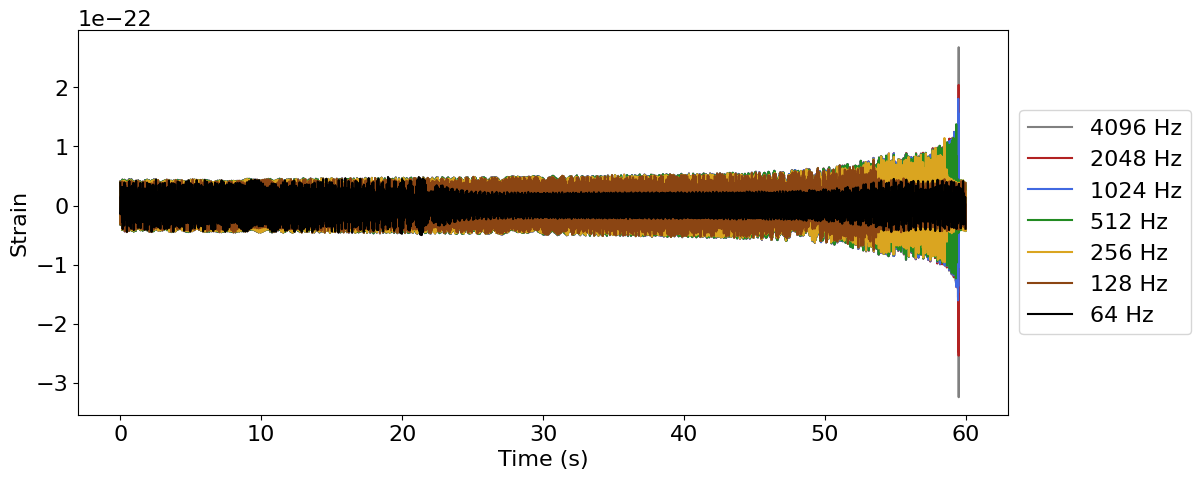

In [17]:
plt.figure(figsize=(12,5))
plt.plot(result_mid[4096]['t'], result_mid[4096]['hp'],color='grey',label='4096 Hz')
plt.plot(result_mid[2048]['t'], result_mid[2048]['hp'],color='firebrick',label='2048 Hz')
plt.plot(result_mid[1024]['t'], result_mid[1024]['hp'],color='royalblue',label='1024 Hz')
plt.plot(result_mid[512]['t'], result_mid[512]['hp'],color='forestgreen',label='512 Hz')
plt.plot(result_mid[256]['t'], result_mid[256]['hp'],color='goldenrod',label='256 Hz')
plt.plot(result_mid[128]['t'], result_mid[128]['hp'],color='saddlebrown',label='128 Hz')
plt.plot(result_mid[64]['t'], result_mid[64]['hp'],color='black',label='64 Hz')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(59.475,59.496)
plt.show()

In [18]:
fixed_params_1 = {
    "chirp_mass": torch.tensor([2.2]),
    "mass_ratio": torch.tensor([1.0]),
    "chi1": torch.tensor([0.0]),
    "chi2": torch.tensor([0.0]),
    "distance": torch.tensor([50.0]),  # Mpc 10 - 500
    "phic": torch.tensor([0.0]),
    "inclination": torch.tensor([1.0])
}

In [19]:
result_high = generate_multi_sr_waveforms(
    sample_rates=sample_rates,
    params_dict=fixed_params_1,
    waveform_duration=60,
    f_ref=20
)

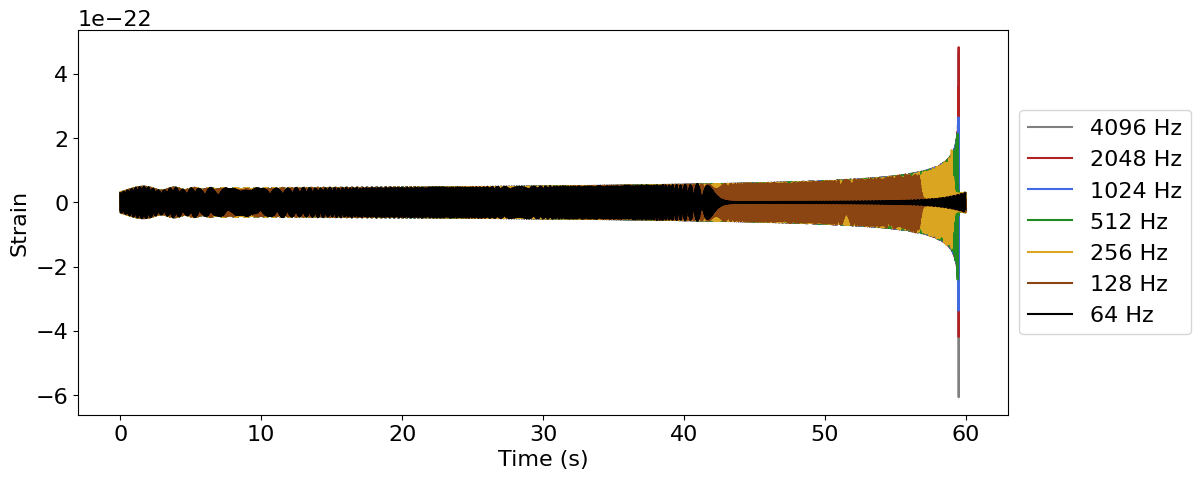

In [20]:
plt.figure(figsize=(12,5))
plt.plot(result_high[4096]['t'], result_high[4096]['hp'],color='grey',label='4096 Hz')
plt.plot(result_high[2048]['t'], result_high[2048]['hp'],color='firebrick',label='2048 Hz')
plt.plot(result_high[1024]['t'], result_high[1024]['hp'],color='royalblue',label='1024 Hz')
plt.plot(result_high[512]['t'], result_high[512]['hp'],color='forestgreen',label='512 Hz')
plt.plot(result_high[256]['t'], result_high[256]['hp'],color='goldenrod',label='256 Hz')
plt.plot(result_high[128]['t'], result_high[128]['hp'],color='saddlebrown',label='128 Hz')
plt.plot(result_high[64]['t'], result_high[64]['hp'],color='black',label='64 Hz')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(50,60)
plt.show()

In [21]:
fixed_params_2 = {
    "chirp_mass": torch.tensor([1.17]),
    "mass_ratio": torch.tensor([1.0]),
    "chi1": torch.tensor([0.0]),
    "chi2": torch.tensor([0.0]),
    "distance": torch.tensor([50.0]),  # Mpc 10 - 500
    "phic": torch.tensor([0.0]),
    "inclination": torch.tensor([1.0])
}

In [22]:
result_low = generate_multi_sr_waveforms(
    sample_rates=sample_rates,
    params_dict=fixed_params_2,
    waveform_duration=60,
    f_ref=20
)

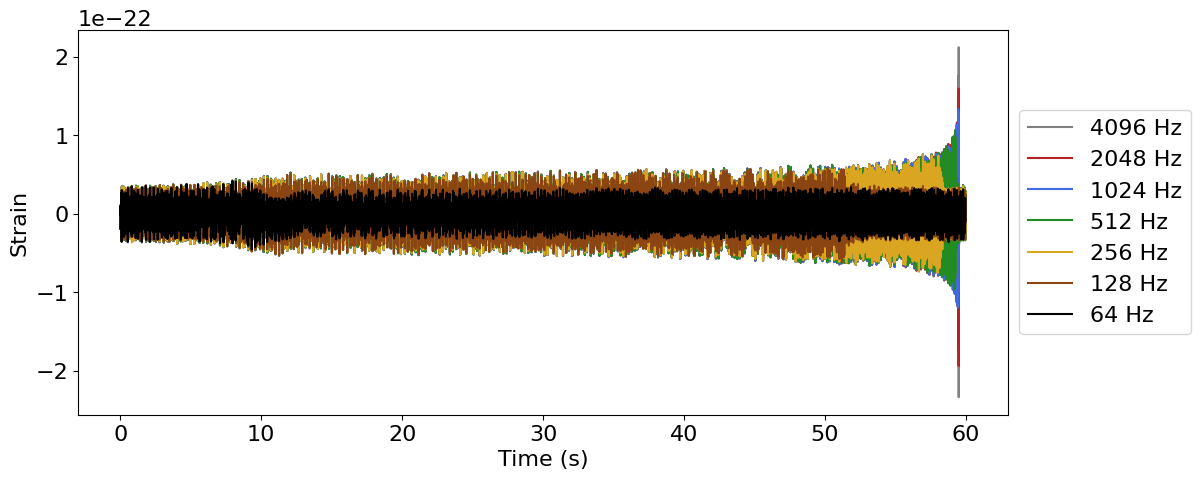

In [23]:
plt.figure(figsize=(12,5))
plt.plot(result_low[4096]['t'], result_low[4096]['hp'],color='grey',label='4096 Hz')
plt.plot(result_low[2048]['t'], result_low[2048]['hp'],color='firebrick',label='2048 Hz')
plt.plot(result_low[1024]['t'], result_low[1024]['hp'],color='royalblue',label='1024 Hz')
plt.plot(result_low[512]['t'], result_low[512]['hp'],color='forestgreen',label='512 Hz')
plt.plot(result_low[256]['t'], result_low[256]['hp'],color='goldenrod',label='256 Hz')
plt.plot(result_low[128]['t'], result_low[128]['hp'],color='saddlebrown',label='128 Hz')
plt.plot(result_low[64]['t'], result_low[64]['hp'],color='black',label='64 Hz')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(20,20.2)
plt.show()

In [24]:
# fn = lambda x: t_chirp(chirp_mass=1.04, f_1=x, f_2=128) - 18
# fn(200)
# from scipy.optimize import brentq
# brentq(fn, 20, 4096)

In [25]:
def generate_variable_rate_waveform(waveform, sr=2048, schedule=None, device=None):
    """
    Downsample a waveform into variable-rate segments using vectorized advanced indexing.
    No Python loops, single gather operation.

    Parameters
    ----------
    waveform : torch.Tensor
        High-resolution waveform sampled at sr Hz
    sr : int
        Original sampling rate
    schedule : torch.Tensor
        [num_segments, 3] -> [start_time, end_time, target_sr]
    device : str or torch.device
        Device for computation

    Returns
    -------
    waveform_var : torch.Tensor
        Concatenated waveform sampled at different rates
    times : torch.Tensor
        Corresponding time axis [M]
    """

    if schedule is None:
        schedule = torch.tensor([[0, 40, 256],
                                 [40, 58, 512],
                                 [58, 60, 2048]])

    # Extract schedule
    start, end, target_sr = schedule.T # [N]
    
    # Compute number of samples per segment
    samples = ((end - start) * target_sr).long() # [N]
    max_len = samples.max()

    # Build grid of relative indices
    rel_idx = torch.arange(max_len).expand(len(samples), -1)

    # Mask valid indices
    mask = rel_idx < samples.unsqueeze(1)

    # Compute absolute indices in original waveform
    abs_idx = (start.unsqueeze(1) * sr + rel_idx * (sr / target_sr.unsqueeze(1))).long()

    # Keep only valid indices
    all_indices = abs_idx[mask]

    # Slice waveform in one go
    waveform_var = waveform[all_indices]
    times = all_indices.float() / sr

    return waveform_var, times

In [26]:
import time
start_time = time.time()

h_var_mid, times_mid = generate_variable_rate_waveform(
    waveform=result_mid[2048]['hp'], 
    sr=2048, 
    schedule=None,
    device=device
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.0122 seconds


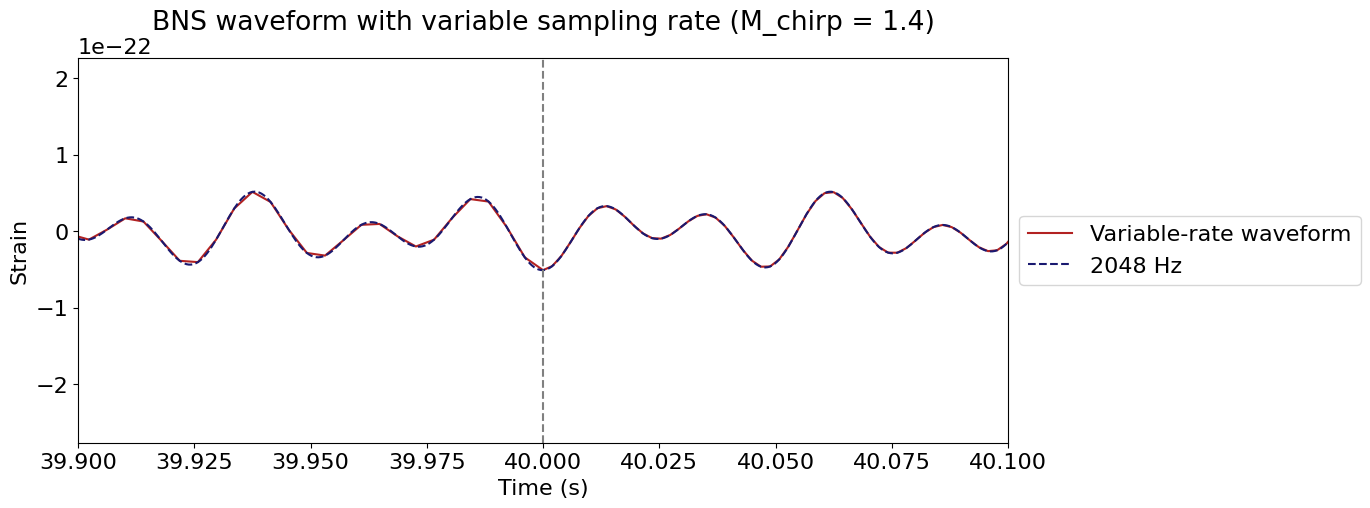

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(times_mid.cpu(), h_var_mid.cpu().squeeze(), color='firebrick', label='Variable-rate waveform')
plt.plot(result_mid[2048]['t'], result_mid[2048]['hp'],color='midnightblue', linestyle='--', label='2048 Hz')
plt.axvline(40, linestyle='--', color='grey')
plt.axvline(58, linestyle='--', color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("BNS waveform with variable sampling rate (M_chirp = 1.4)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(39.9,40.1)
plt.show()

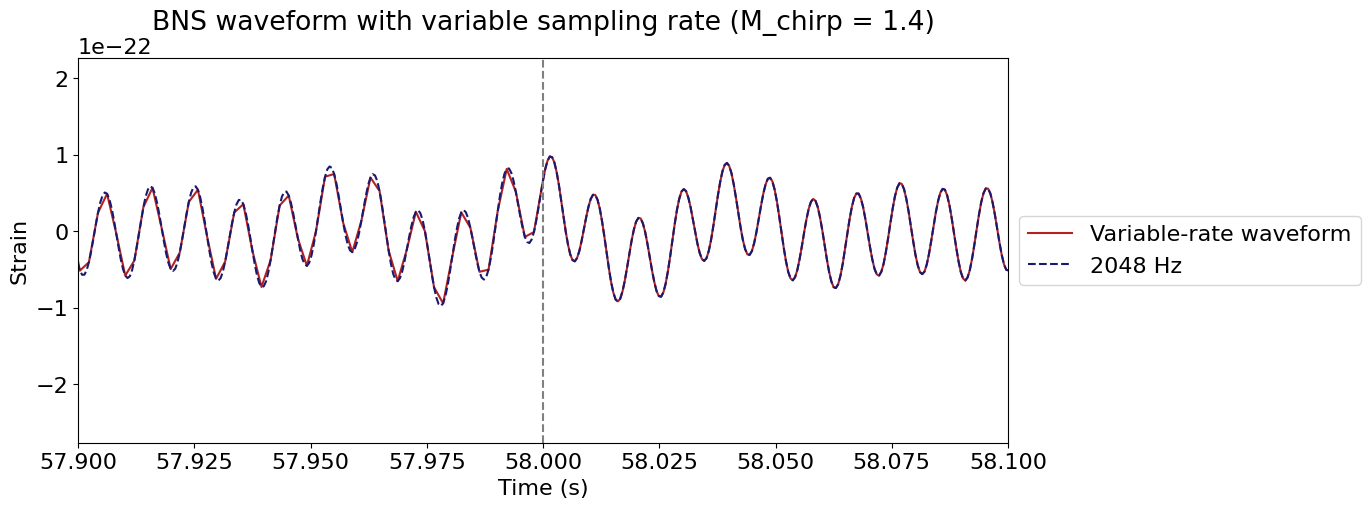

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(times_mid.cpu(), h_var_mid.cpu().squeeze(), color='firebrick', label='Variable-rate waveform')
plt.plot(result_mid[2048]['t'], result_mid[2048]['hp'],color='midnightblue', linestyle='--', label='2048 Hz')
plt.axvline(40, linestyle='--', color='grey')
plt.axvline(58, linestyle='--', color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("BNS waveform with variable sampling rate (M_chirp = 1.4)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(57.9,58.1)
plt.show()

In [29]:
h_var_high, times_high = generate_variable_rate_waveform(
    waveform=result_high[2048]['hp'], 
    sr=2048, 
    schedule=None,
    device=device
)

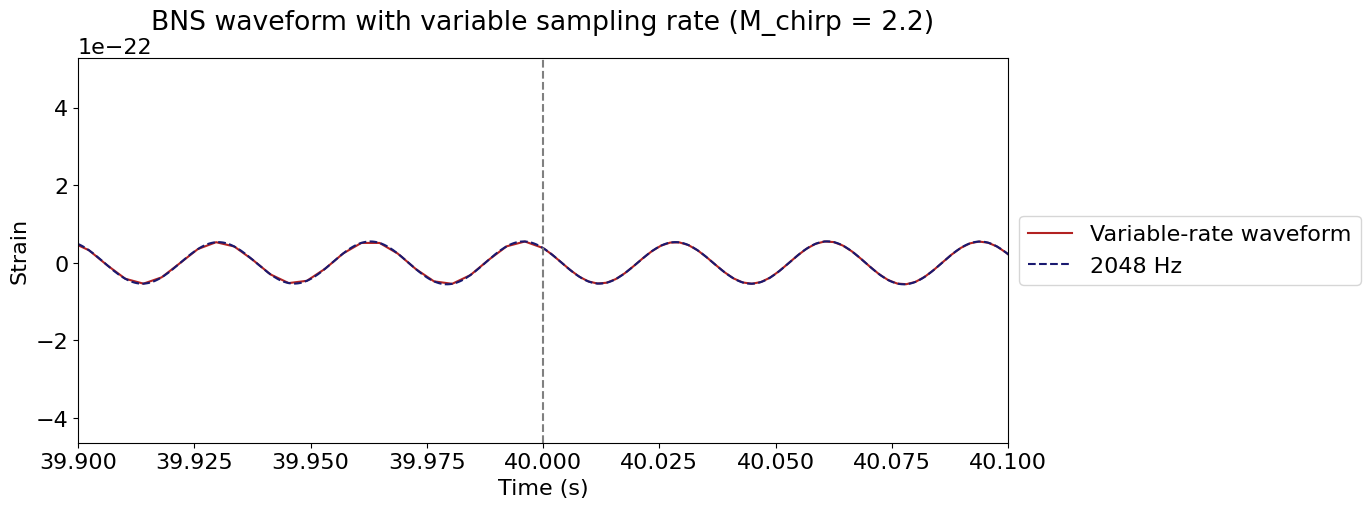

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(times_high.cpu(), h_var_high.cpu().squeeze(), color='firebrick', label='Variable-rate waveform')
plt.plot(result_high[2048]['t'], result_high[2048]['hp'],color='midnightblue',linestyle='--', label='2048 Hz')
plt.axvline(40, linestyle='--', color='grey')
plt.axvline(58, linestyle='--', color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("BNS waveform with variable sampling rate (M_chirp = 2.2)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(39.9,40.1)
plt.show()

In [31]:
h_var_low, times_low = generate_variable_rate_waveform(
    waveform=result_low[2048]['hp'], 
    sr=2048, 
    schedule=None,
    device=device
)

In [32]:
print(f_low(delta_t=40, chirp_mass=1.17, f_2=64, device=device))
print(t_chirp(chirp_mass=1.17, f_1=32, f_2=64, device=device))

tensor([32.1489], device='cuda:0')
tensor([40.5929], device='cuda:0')


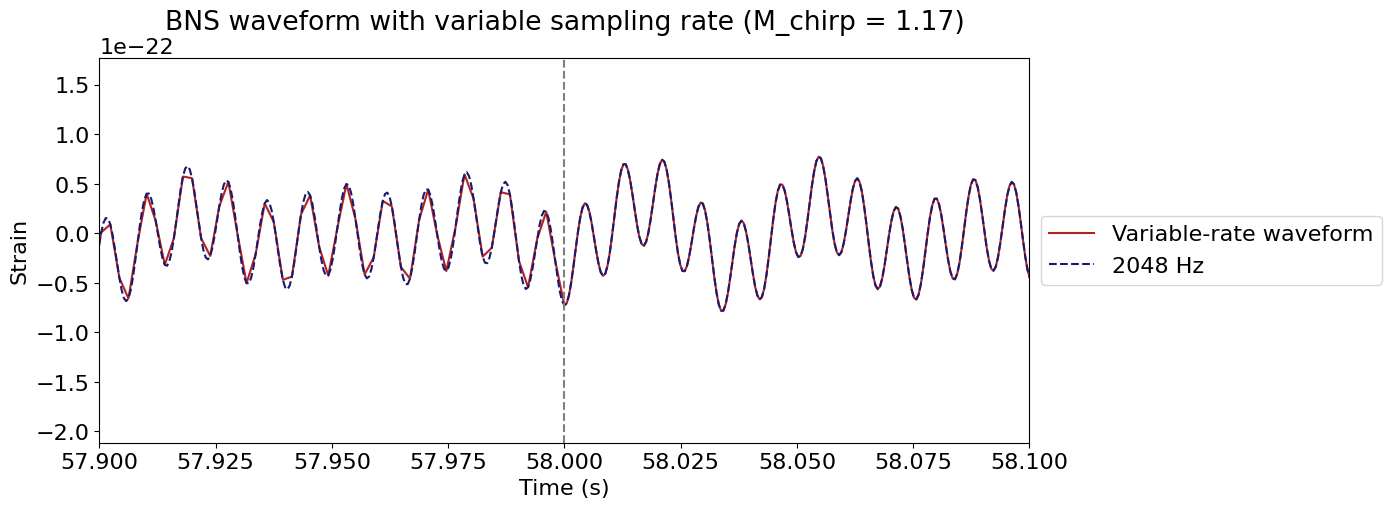

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(times_low.cpu(), h_var_low.cpu().squeeze(), color='firebrick', label='Variable-rate waveform')
plt.plot(result_low[2048]['t'], result_low[2048]['hp'],color='midnightblue', linestyle='--', label='2048 Hz')
plt.axvline(40, linestyle='--', color='grey')
plt.axvline(58, linestyle='--', color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("BNS waveform with variable sampling rate (M_chirp = 1.17)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(57.9,58.1)
plt.show()

In [34]:
fixed_params_3 = {
    "chirp_mass": torch.tensor([1.04]),
    "mass_ratio": torch.tensor([1.0]),
    "chi1": torch.tensor([0.0]),
    "chi2": torch.tensor([0.0]),
    "distance": torch.tensor([50.0]),  # Mpc 10 - 500
    "phic": torch.tensor([0.0]),
    "inclination": torch.tensor([1.0])
}

In [35]:
result_low1 = generate_multi_sr_waveforms(
    sample_rates=sample_rates,
    params_dict=fixed_params_3,
    waveform_duration=60,
    f_ref=20
)

In [36]:
import time
start_time = time.time()
h_var_low1, times_low1 = generate_variable_rate_waveform(
        waveform=result_low1[2048]['hp'],      
        sr=2048,            
        schedule=None,      
        device=device
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")


Elapsed time: 0.0017 seconds


In [37]:
print(f_low(delta_t=18, chirp_mass=1.04, f_2=128, device=device))
print(t_chirp(chirp_mass=1.04, f_1=64, f_2=128, device=device))

tensor([48.3970], device='cuda:0')
tensor([7.7796], device='cuda:0')


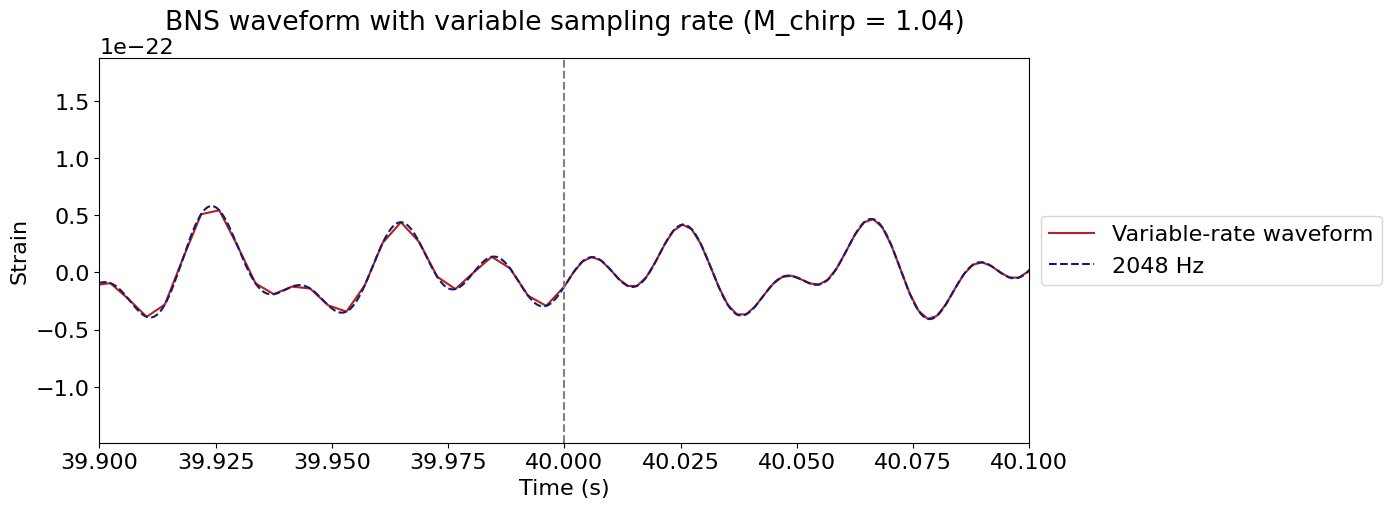

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(times_low1.cpu(), h_var_low1.cpu().squeeze(), color='firebrick', label='Variable-rate waveform')
plt.plot(result_low1[2048]['t'], result_low1[2048]['hp'],color='midnightblue', linestyle='--', label='2048 Hz')
plt.axvline(x=40, color='grey', linestyle='--')
plt.axvline(x=58, color='grey', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("BNS waveform with variable sampling rate (M_chirp = 1.04)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(39.9,40.1)
plt.show()

In [40]:
def build_variable_indices(sr=2048, schedule=None, device=None):
        if schedule is None:
            schedule = torch.tensor([[0, 40, 256],
                                    [40, 58, 512],
                                    [58, 60, 2048]], dtype=torch.int, device=device)

        idx = torch.tensor([], dtype=torch.long, device=device)
        for s in schedule:
            if idx.size()[0] == 0:
                start = int(s[0] * sr)
            else:
                start = int(idx[-1]) + int(idx[-1] - idx[-2])
            stop = int(start + (s[1] - s[0]) * sr)
            step = int(sr // s[2])
            idx = torch.cat((idx, torch.arange(start, stop, step, dtype=torch.int, device=device)))
        return idx

In [112]:
indices = build_variable_indices(sr=2048)
X2 = result_low1[2048]['hp'].index_select(dim=-1, index=indices)

In [113]:
time1 = torch.arange(0, 40, 1 / 256)
time2 = torch.arange(0, 18, 1 / 512) + time1[-1] + (1 / 256)  
time3 = torch.arange(0, 2, 1 / 2048) + time2[-1] + (1 / 512)
timet = torch.cat([time1, time2, time3])

time = torch.arange(0, 60, 1 / 2048)

(-1.488475716936738e-22, 1.8778872471416105e-22)

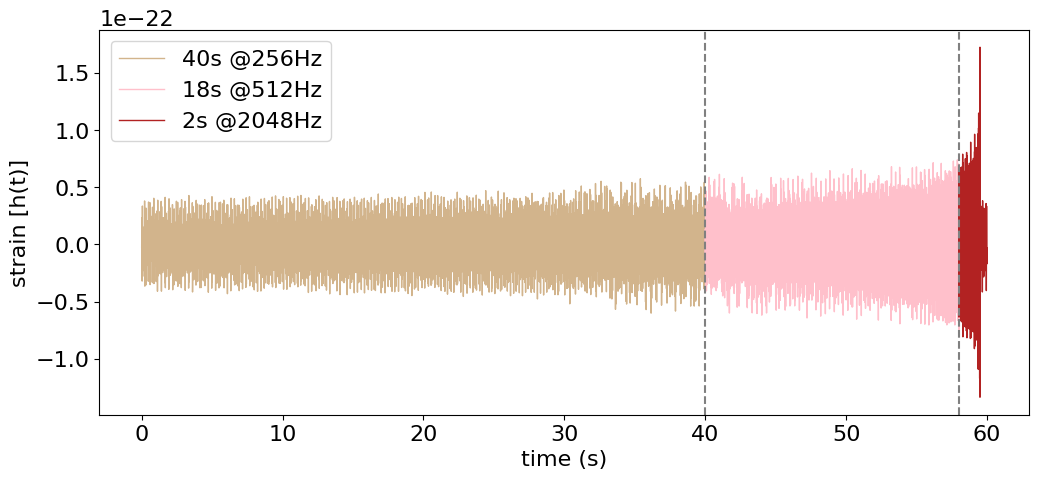

In [114]:
plt.figure(figsize=(12, 5))

plt.plot(time1, X2[:10240], color='tan', linewidth=1, label='40s @256Hz')
plt.plot(time2, X2[10240:19456], color='pink', linewidth=1, label='18s @512Hz')
plt.plot(time3, X2[19456:], color='firebrick', linewidth=1, label='2s @2048Hz')


plt.axvline(x=40, color='grey', linestyle='--')
plt.axvline(x=58, color='grey', linestyle='--')

plt.xlabel('time (s)')
plt.ylabel('strain [h(t)]')

plt.legend(loc='best')
# plt.xlim(57.9, 58.1)
# plt.xlim(59.4, 59.5)
plt.ylim()

In [115]:
import numpy as np
x_up = np.interp(time, timet, X2)

In [ ]:
from scipy.interpolate import interp1d
f = interp1d(timet.numpy(), X2.numpy(), kind="cubic")
x_up2 = f(time.numpy())

(-1.488475716936738e-22, 1.8778872471416105e-22)

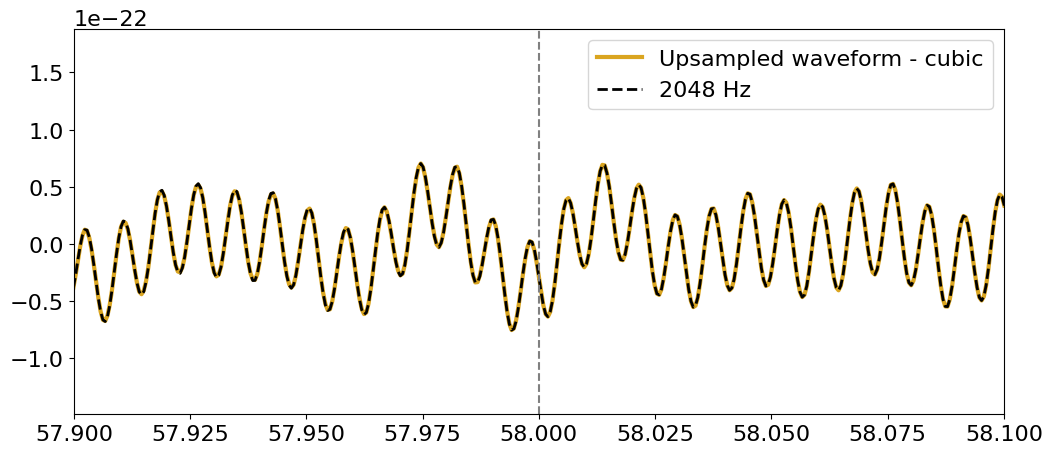

In [117]:
plt.figure(figsize=(12, 5))
# plt.plot(time, x_up, color='royalblue', linewidth=3, label='Upsampled waveform - linear')
plt.plot(time, x_up2, color='goldenrod', linewidth=3, label='Upsampled waveform - cubic')
plt.plot(result_low1[2048]['t'], result_low1[2048]['hp'], linewidth=2, color='black', linestyle='--', label='2048 Hz')

plt.axvline(x=40, color='grey', linestyle='--')
plt.axvline(x=58, color='grey', linestyle='--')

plt.legend(loc='best')
plt.xlim(57.9, 58.1)
# plt.xlim(59.4, 59.5)
plt.ylim()

In [118]:
np.allclose(result_low1[2048]['hp']*1e22, x_up2*1e22, atol=1e-2)

True

In [159]:
fixed_params_4 = {
    "chirp_mass": torch.tensor([20]),
    "mass_ratio": torch.tensor([0.6]),
    "chi1": torch.tensor([-0.65]),
    "chi2": torch.tensor([0.65]),
    "distance": torch.tensor([110.0]),  # Mpc 10 - 500
    "phic": torch.tensor([0.0]),
    "inclination": torch.tensor([1.0])
}

In [160]:
result_bbh = generate_multi_sr_waveforms(
    sample_rates=sample_rates,
    params_dict=fixed_params_4,
    waveform_duration=60,
    f_ref=20
)

In [161]:
X3 = result_bbh[2048]['hp'].index_select(dim=-1, index=indices)

(-3.146633713171315e-21, 3.3500092741922965e-21)

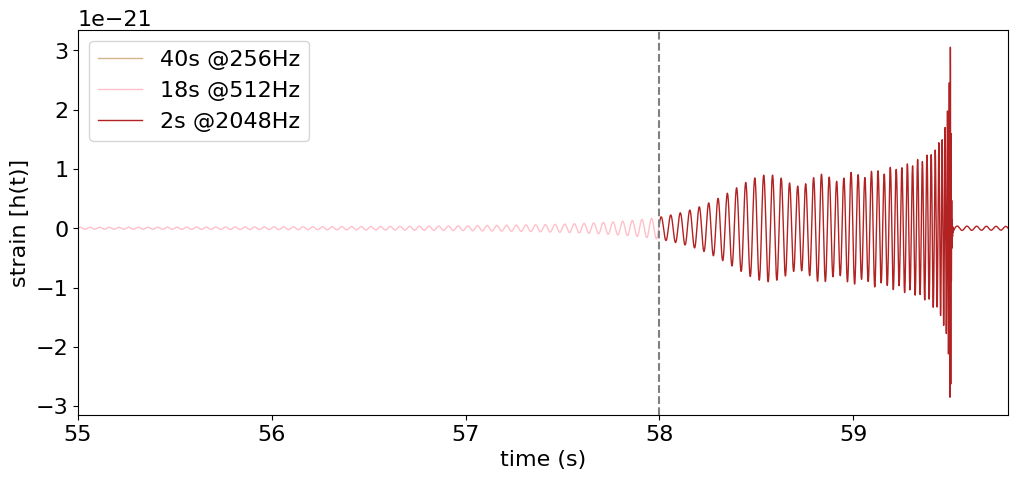

In [162]:
plt.figure(figsize=(12, 5))

plt.plot(time1, X3[:10240], color='tan', linewidth=1, label='40s @256Hz')
plt.plot(time2, X3[10240:19456], color='pink', linewidth=1, label='18s @512Hz')
plt.plot(time3, X3[19456:], color='firebrick', linewidth=1, label='2s @2048Hz')


plt.axvline(x=40, color='grey', linestyle='--')
plt.axvline(x=58, color='grey', linestyle='--')

plt.xlabel('time (s)')
plt.ylabel('strain [h(t)]')

plt.legend(loc='best')
# plt.xlim(57.9, 58.1)
# plt.xlim(59.4, 59.5)
plt.xlim(55, 59.8)
plt.ylim()

In [163]:
import numpy as np
x_up1 = np.interp(time, timet, X3)

In [164]:
from scipy.interpolate import interp1d
f = interp1d(timet.numpy(), X3.numpy(), kind="cubic")
x_up3 = f(time.numpy())

(-3.146633713171315e-21, 3.3500092741922965e-21)

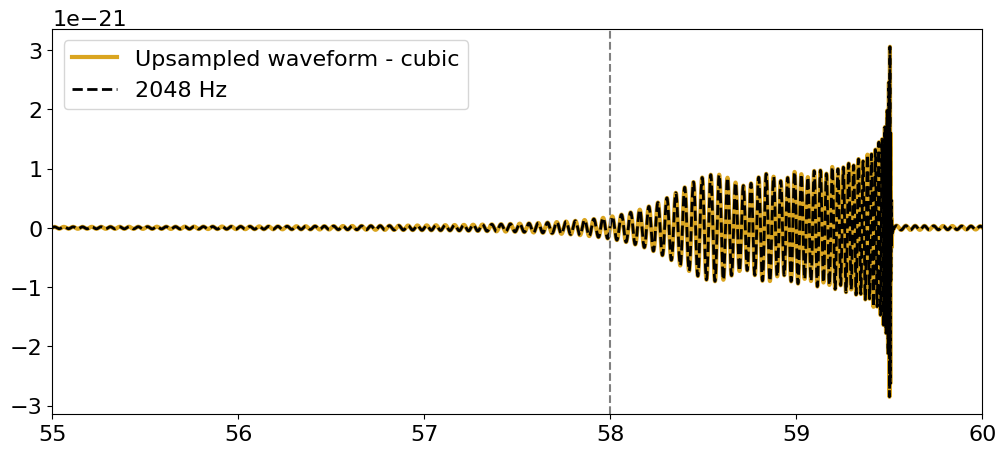

In [165]:
plt.figure(figsize=(12, 5))
plt.plot(time, x_up3, color='goldenrod', linewidth=3, label='Upsampled waveform - cubic')
plt.plot(result_low1[2048]['t'], result_bbh[2048]['hp'], linewidth=2, color='black', linestyle='--', label='2048 Hz')

plt.axvline(x=40, color='grey', linestyle='--')
plt.axvline(x=58, color='grey', linestyle='--')

plt.legend(loc='best')
# plt.xlim(57.9, 58.1)
# plt.xlim(59.4, 59.5)
plt.xlim(55, 60)
plt.ylim()

In [166]:
np.allclose(result_bbh[2048]['hp']*1e21, x_up3*1e21, atol=1e-2)

True